In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
include("../src/unit_commitments.jl")
include("../src/network_analysis.jl")
include("../src/plots.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));
gen_to_zone_dict = Dict(zip(gen_df.r_id, gen_df.zone));

In [3]:
# A spring day
n=100
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time):(final_time)

loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]
gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]
uc_solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 51324 rows; 27300 cols; 153375 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
36965 rows, 26870 cols, 132488 nonzeros  0s
28077 rows, 21432 cols, 114718 nonzeros  0s
20849 rows, 19722 cols, 104541 nonzeros  0s
17632 rows, 16812 cols, 99758 nonzeros  1s
16093 rows, 15376 cols, 95231 nonzeros  2s

Solving MIP model with:
   16093 rows
   15376 cols (8838 binary, 0 integer, 0 implied int., 6538 continuous, 0 domain fixed)
   95231 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

In [4]:
gen_var_actuals = copy(gen_var_multi)
gen_var_actuals.cf .= gen_var_actuals.cf .* (0.95 .+ 0.1 .* rand(nrow(gen_var_actuals)));

loads_multi.demand .= loads_multi.demand .* 1.2;

In [5]:
actual_solution = evaluate_commitment_on_actuals(
    uc_solution,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
);

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 37852 rows; 20350 cols; 89267 nonzeros; 3475 integer variables (0 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [1e+00, 3e+03]
  Bound  [2e-15, 1e+00]
  RHS    [2e+00, 3e+05]
Presolving model
5704 rows, 5274 cols, 14400 nonzeros  0s
2517 rows, 4466 cols, 9656 nonzeros  0s
1767 rows, 3680 cols, 7502 nonzeros  0s
1767 rows, 3680 cols, 7502 nonzeros  0s

Solving MIP model with:
   1767 rows
   3680 cols (0 binary, 0 integer, 0 implied int., 3680 continuous, 0 domain fixed)
   7502 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree

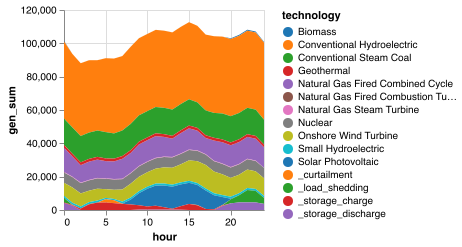

In [6]:
sol_gen_actual = plot_actual_generation(
    actual_solution, T_period,
    gen_df, zone_dict,
    "Total Generation under Actual Conditions"
);

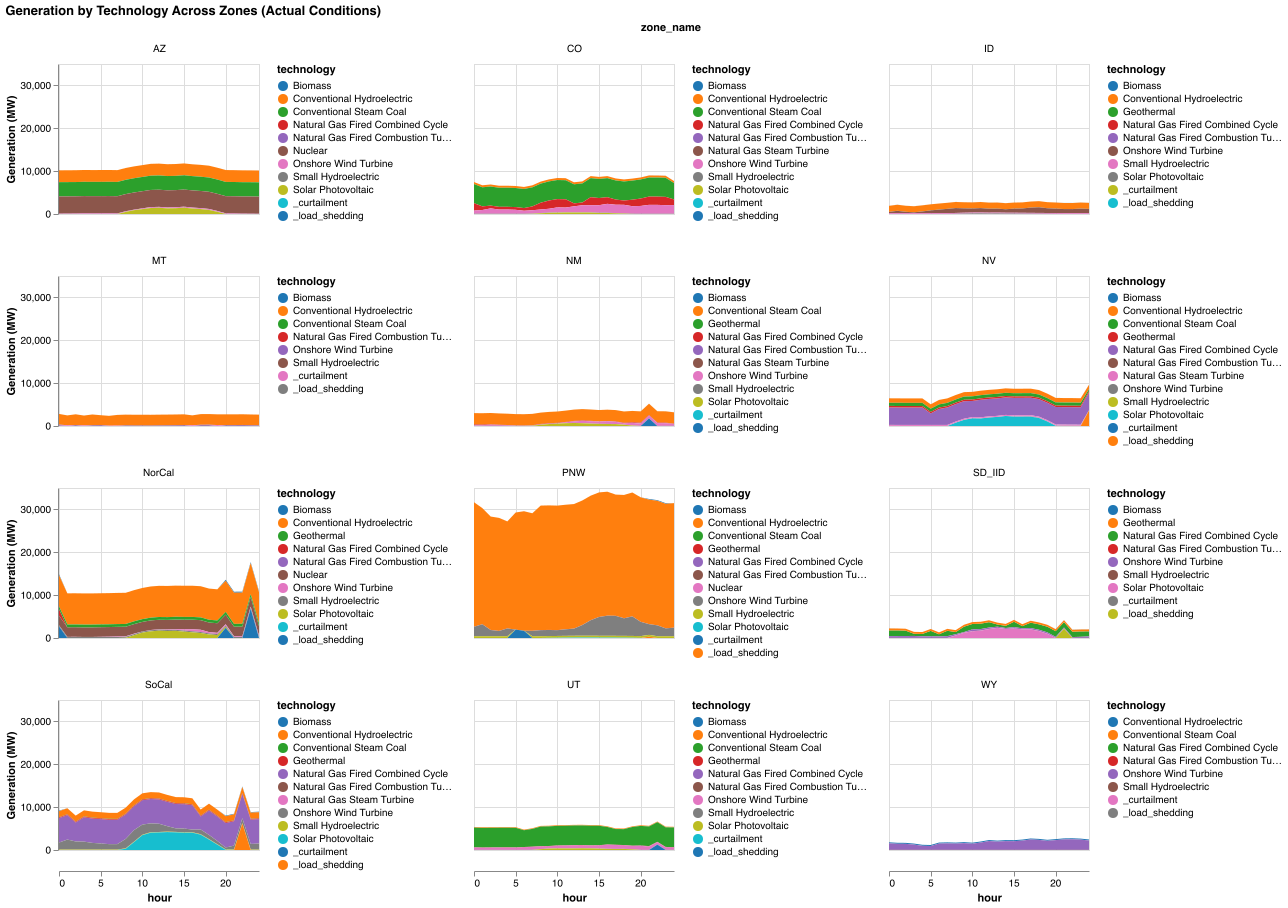

In [7]:
sol_gen_actual_by_zone = plot_actual_generation_by_zone(
    actual_solution, T_period,
    gen_df, zone_dict,
    "Generation by Technology Across Zones (Actual Conditions)"
);

In [8]:
include("../src/network_analysis.jl")
plots_dir = "evaluation_plots"
if !isdir(plots_dir)
    mkpath(plots_dir)
end

plot_power_network(
    actual_solution.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "network_hour_2418.png")
)

animate_power_network(
    actual_solution.flows,
    network,
    gen_df,
    zone_dict;
    hours=2406:2430,
    save_path=joinpath(plots_dir, "network_animation.gif")
)

plot_flow_heatmap(
    actual_solution.flows,
    network,
    line_dict;
    save_path=joinpath(plots_dir, "flow_heatmap.png")
)

# compare_network_flows(
#     solution.flows,
#     ruc_solution.flows,
#     network,
#     gen_df,
#     zone_dict;
#     hour=2418,
#     save_path=joinpath(plots_dir, "flow_comparison.png")
# )

plot_congestion_analysis(
    actual_solution.flows,
    network;
    save_path=joinpath(plots_dir, "congestion_analysis.png")
);

[ Info: Saved animation to /Users/eddiek/Documents/GitHub/intraday-commitments/model_notebooks/evaluation_plots/network_animation.gif


Animation saved to evaluation_plots/network_animation.gif
